<a href="https://colab.research.google.com/github/oneoftwo/generative_model_tutorials/blob/main/AE.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Autoencoder**

  0%|          | 0/9912422 [00:00<?, ?it/s]

Extracting ./MNIST_DATASET/MNIST/raw/train-images-idx3-ubyte.gz to ./MNIST_DATASET/MNIST/raw



  0%|          | 0/28881 [00:00<?, ?it/s]

Extracting ./MNIST_DATASET/MNIST/raw/train-labels-idx1-ubyte.gz to ./MNIST_DATASET/MNIST/raw



  0%|          | 0/1648877 [00:00<?, ?it/s]

Extracting ./MNIST_DATASET/MNIST/raw/t10k-images-idx3-ubyte.gz to ./MNIST_DATASET/MNIST/raw



  0%|          | 0/4542 [00:00<?, ?it/s]

Extracting ./MNIST_DATASET/MNIST/raw/t10k-labels-idx1-ubyte.gz to ./MNIST_DATASET/MNIST/raw



/usr/local/lib/python3.7/dist-packages/torchvision/datasets/mnist.py:498: UserWarning: The given NumPy array is not writeable, and PyTorch does not support non-writeable tensors. This means you can write to the underlying (supposedly non-writeable) NumPy array using the tensor. You may want to copy the array to protect its data or make it writeable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at  /pytorch/torch/csrc/utils/tensor_numpy.cpp:180.)
  return torch.from_numpy(parsed.astype(m[2], copy=False)).view(*s)


size of encoded latent torch.Size([128, 2]) True
size of regenerated image torch.Size([128, 1, 28, 28]) True


100%|██████████| 1875/1875 [00:29<00:00, 63.73it/s]


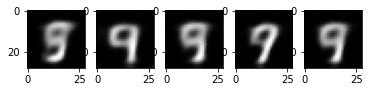

106.98328300192952


100%|██████████| 1875/1875 [00:29<00:00, 64.65it/s]


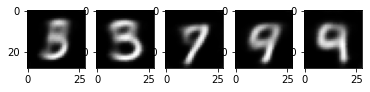

80.47222046554089


100%|██████████| 1875/1875 [00:29<00:00, 64.40it/s]


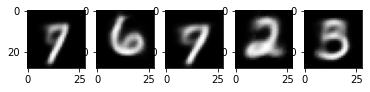

75.9023629501462


100%|██████████| 1875/1875 [00:29<00:00, 64.46it/s]


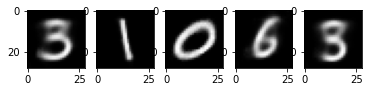

73.58577759377658


 78%|███████▊  | 1469/1875 [00:22<00:06, 64.85it/s]

In [ ]:
import numpy as np
import random as random
import time as time
from tqdm import tqdm

import torch
from torch import nn
from torch.nn import functional as F
from torch.utils.data import DataLoader
from torchvision.datasets import MNIST
from torchvision import transforms
from torch import optim

from matplotlib import pyplot as plt
from matplotlib import cm


batch_size = 32
# Normalize data with mean=0.5, std=1.0
download_root = './MNIST_DATASET'
train_dataset = MNIST(download_root, transform=transforms.ToTensor(), \
    train=True, download=True)
test_dataset = MNIST(download_root, transform=transforms.ToTensor(), \
    train=False, download=True)
train_loader = DataLoader(dataset=train_dataset, batch_size=batch_size, \
    shuffle=True)
test_loader = DataLoader(dataset=test_dataset, batch_size=batch_size, \
    shuffle=True)


################################################################################
# autoencoder ##################################################################


# encoder for autoencoder
class AutoencoderEncoder(nn.Module):

    def __init__(self):
        super().__init__()
        self.conv_layers = nn.Sequential(\
            nn.Conv2d(1, 32, kernel_size=5, stride=1, padding=1, bias=False), \
            nn.SiLU(), \
            nn.Conv2d(32, 32, kernel_size=3, stride=1, padding=1, bias=False), \
            nn.SiLU(), \
            nn.Conv2d(32, 64, kernel_size=2, stride=2, padding=0, bias=False), \
            nn.SiLU(), \
            nn.Conv2d(64, 64, kernel_size=3, stride=1, padding=1, bias=False), \
            nn.SiLU(), \
            nn.Conv2d(64, 128, kernel_size=2, stride=2, padding=0, bias=False), \
            )
        self.fc = nn.Sequential(\
            nn.Linear(6 * 6 * 128, 1000), \
            nn.SiLU(), \
            nn.Linear(1000, 100), \
            nn.SiLU(), \
            nn.Linear(100, 2)
            )

    def forward(self, x):
        b = x.size(0)
        x = self.conv_layers(x)
        x = x.view(b, -1)
        x = self.fc(x)
        return x # 2 dim


# decoder for autoencoder
class AutoencoderDecoder(nn.Module):

    def __init__(self):
        super().__init__()
        self.fc = nn.Sequential(\
            nn.Linear(2, 100), \
            nn.SiLU(), \
            nn.Linear(100, 1000), \
            nn.SiLU(), \
            nn.Linear(1000, 128 * 6 * 6)
            )
        self.conv_layers = nn.Sequential(\
            nn.ConvTranspose2d(128, 64, kernel_size=2, stride=2, padding=0, bias=False), \
            nn.SiLU(), \
            nn.ConvTranspose2d(64, 64, kernel_size=3, stride=1, padding=1, bias=False), \
            nn.SiLU(), \
            nn.ConvTranspose2d(64, 32, kernel_size=2, stride=2, padding=0, bias=False), \
            nn.SiLU(), \
            nn.ConvTranspose2d(32, 32, kernel_size=3, stride=1, padding=1, bias=False), \
            nn.SiLU(), \
            nn.ConvTranspose2d(32, 1, kernel_size=5, stride=1, padding=0, bias=False), \
            )
        
    def forward(self, x):
        b = x.size(0)
        x = self.fc(x)
        x = x.view(b, 128, 6, 6)
        x = self.conv_layers(x)
        return x # 28 28 


# autoencoder
class Autoencoder(nn.Module):
    
    def __init__(self):
        super().__init__()
        self.encoder = AutoencoderEncoder()
        self.decoder = AutoencoderDecoder()

    def forward(self, x):
        z = self.encoder(x)
        x_regen = self.decoder(z)
        x_regen = torch.sigmoid(x_regen)
        return x_regen, z
    

################################################################################


################################################################################
# sanity check #################################################################
x = torch.rand(128, 1, 28, 28)
auto = Autoencoder()
x_regen ,z = auto(x)
print('size of encoded latent', z.size(), z.requires_grad)
print('size of regenerated image', x_regen.size(), x_regen.requires_grad)
################################################################################
################################################################################
# train model ##################################################################

# train single epoch
def train_autoencoder_single_epoch(model, dataloader):
    model.train().cuda()
    criterion = nn.MSELoss()
    optimizer = optim.Adam(model.parameters(), lr=0.0001)
    epoch_loss = 0

    for imgs, labels in tqdm(dataloader):
        optimizer.zero_grad()
        imgs = imgs.cuda()
        imgs_regen, z = model(imgs)
        loss = criterion(imgs_regen.view(-1, 784), imgs.view(-1, 784))
        loss.backward()
        optimizer.step()
        epoch_loss += loss.item()
    # plot regen imgs
    fig = plt.figure(figsize=(6, 30))
    for idx in range(5):
        img = imgs_regen[idx].cpu().squeeze().detach().numpy()
        ax = fig.add_subplot(1, 5, idx + 1)
        ax.imshow(img, cmap=cm.gray)
    plt.show()
    return epoch_loss

# train
def train_autoencoder(model, dataloader, n_epoch=30):
    loss_list = []
    model
    for _ in range(n_epoch):
        epoch_loss = train_autoencoder_single_epoch(model, dataloader)
        print(epoch_loss)
    return model
################################################################################


################################################################################
# exe ##########################################################################
model = Autoencoder()
trained_ae = train_autoencoder(model, train_loader)
################################################################################

In [ ]:
def plot_scatter(model, loader):
    # get z sampling
    model.cpu()
    z_sampled = []
    label_sampled = []
    for imgs, labels in loader:
        _, z = model(imgs)
        z_sampled.append(z) # z[b 2]
        label_sampled.append(labels)
    del imgs
    z_to_plot = torch.cat(z_sampled, dim=0).cpu() # z[n 2]
    label_to_plot = torch.cat(label_sampled, dim=0)
    z_to_plot = z_to_plot[:10000,:]
    label_to_plot = label_to_plot[:10000]
    # plot
    x_data = z_to_plot[:,0].squeeze().detach().numpy()
    y_data = z_to_plot[:,1].squeeze().detach().numpy()
    label_data = label_to_plot[:].squeeze().detach().numpy()
    plot_group = [[[],[]], [[],[]], [[],[]], [[],[]], [[],[]], [[],[]], [[],[]], [[],[]], [[],[]], [[],[]]]
    for idx in range(len(x_data)):
        label = label_data[idx]
        plot_group[label][0].append(x_data[idx])
        plot_group[label][1].append(y_data[idx])
    plt.figure(figsize=(10,10))
    for number, group in enumerate(plot_group):
        x, y = group
        plt.scatter(x, y, label = str(number))
    plt.legend(fontsize=12, loc='upper left')
    plt.show()
    return None
plot_scatter(trained_ae, test_loader)

NameError: ignored

# **Variational Autoencoder**


  0%|          | 0/9912422 [00:00<?, ?it/s]

Extracting ./mnist_data/MNIST/raw/train-images-idx3-ubyte.gz to ./mnist_data/MNIST/raw



  0%|          | 0/28881 [00:00<?, ?it/s]

Extracting ./mnist_data/MNIST/raw/train-labels-idx1-ubyte.gz to ./mnist_data/MNIST/raw



  0%|          | 0/1648877 [00:00<?, ?it/s]

Extracting ./mnist_data/MNIST/raw/t10k-images-idx3-ubyte.gz to ./mnist_data/MNIST/raw



  0%|          | 0/4542 [00:00<?, ?it/s]

Extracting ./mnist_data/MNIST/raw/t10k-labels-idx1-ubyte.gz to ./mnist_data/MNIST/raw

Epoch: 1 loss: 178.7075


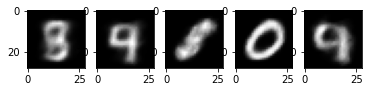

Epoch: 2 loss: 157.7953


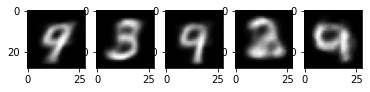

Epoch: 3 loss: 152.1733


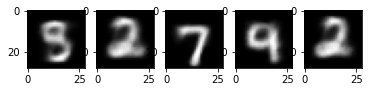

Epoch: 4 loss: 148.9377


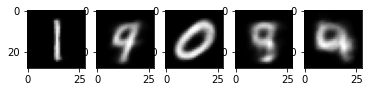

Epoch: 5 loss: 146.8847


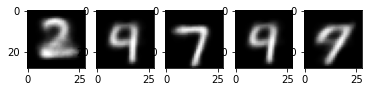

Epoch: 6 loss: 145.5497


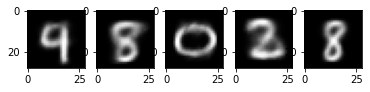

Epoch: 7 loss: 144.3648


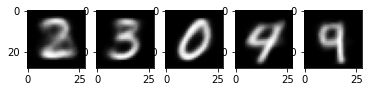

Epoch: 8 loss: 143.5047


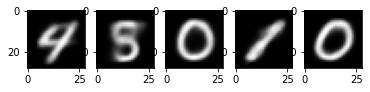

Epoch: 9 loss: 142.7702


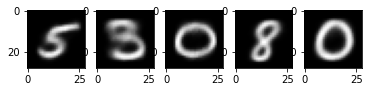

Epoch: 10 loss: 142.2643


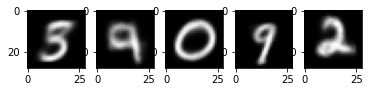

Epoch: 11 loss: 141.5464


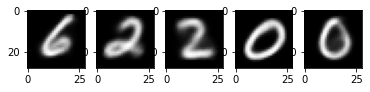

Epoch: 12 loss: 141.2057


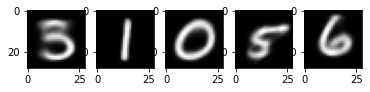

Epoch: 13 loss: 140.6253


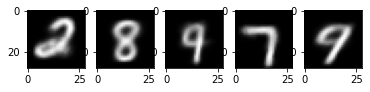

Epoch: 14 loss: 140.2318


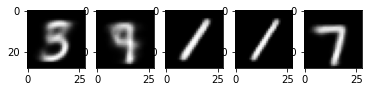

Epoch: 15 loss: 139.7735


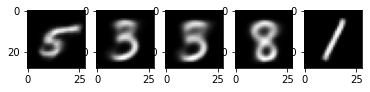

Epoch: 16 loss: 139.5855


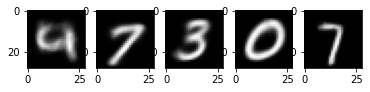

Epoch: 17 loss: 139.0395


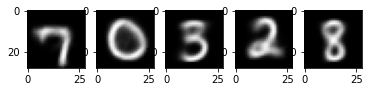

Epoch: 18 loss: 138.8811


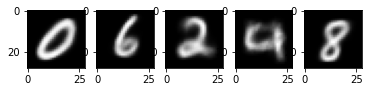

Epoch: 19 loss: 138.5583


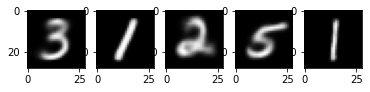

Epoch: 20 loss: 138.3676


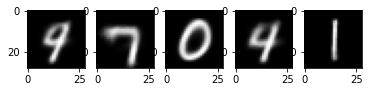

Epoch: 21 loss: 138.1764


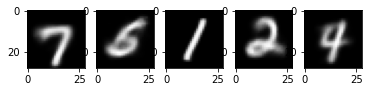

Epoch: 22 loss: 138.0474


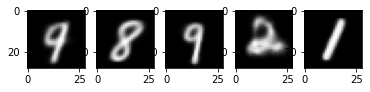

Epoch: 23 loss: 137.9194


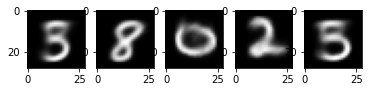

Epoch: 24 loss: 137.6321


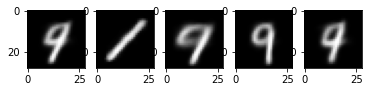

Epoch: 25 loss: 137.5160


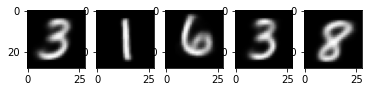

Epoch: 26 loss: 137.2419


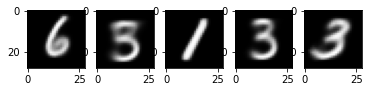

Epoch: 27 loss: 137.0192


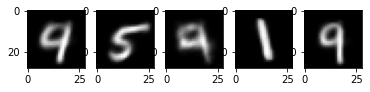

Epoch: 28 loss: 137.0070


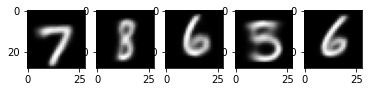

Epoch: 29 loss: 136.9591


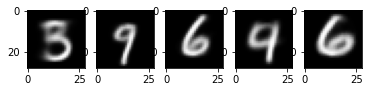

In [ ]:
import numpy as np
import random as random
import time as time
from tqdm import tqdm
from torch.utils.data import DataLoader
from torchvision.datasets import MNIST
from torchvision import transforms
from torch import optim
from matplotlib import pyplot as plt
from matplotlib import cm
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms
from torch.autograd import Variable
from torchvision.utils import save_image

bs = 100
# MNIST Dataset
train_dataset = datasets.MNIST(root='./mnist_data/', train=True, transform=transforms.ToTensor(), download=True)
test_dataset = datasets.MNIST(root='./mnist_data/', train=False, transform=transforms.ToTensor(), download=False)

# Data Loader (Input Pipeline)
train_loader = torch.utils.data.DataLoader(dataset=train_dataset, batch_size=bs, shuffle=True)
test_loader = torch.utils.data.DataLoader(dataset=test_dataset, batch_size=bs, shuffle=False)



class VAE(nn.Module):
    def __init__(self, x_dim, h_dim1, h_dim2, z_dim):
        super(VAE, self).__init__()
        
        # encoder part
        self.fc1 = nn.Linear(x_dim, h_dim1)
        self.fc2 = nn.Linear(h_dim1, h_dim2)
        self.fc31 = nn.Linear(h_dim2, z_dim)
        self.fc32 = nn.Linear(h_dim2, z_dim)
        # decoder part
        self.fc4 = nn.Linear(z_dim, h_dim2)
        self.fc5 = nn.Linear(h_dim2, h_dim1)
        self.fc6 = nn.Linear(h_dim1, x_dim)
        
    def encoder(self, x):
        h = F.relu(self.fc1(x))
        h = F.relu(self.fc2(h))
        return self.fc31(h), self.fc32(h) # mu, log_var
    
    def sampling(self, mu, log_var):
        std = torch.exp(0.5*log_var)
        eps = torch.randn_like(std)
        return eps.mul(std).add_(mu) # return z sample
        
    def decoder(self, z):
        h = F.relu(self.fc4(z))
        h = F.relu(self.fc5(h))
        return torch.sigmoid(self.fc6(h)) 
    
    def forward(self, x):
        mu, log_var = self.encoder(x.view(-1, 784))
        z = self.sampling(mu, log_var)
        return self.decoder(z), mu, log_var, z

# build model
vae = VAE(x_dim=784, h_dim1= 512, h_dim2=256, z_dim=2)
if torch.cuda.is_available():
    vae.cuda()



optimizer = optim.Adam(vae.parameters())
# return reconstruction error + KL divergence losses
def loss_function(recon_x, x, mu, log_var):
    BCE = F.binary_cross_entropy(recon_x, x.view(-1, 784), reduction='sum')
    KLD = -0.5 * torch.sum(1 + log_var - mu.pow(2) - log_var.exp())
    return BCE + KLD

def train(epoch):
    vae.train()
    train_loss = 0
    for batch_idx, (data, _) in enumerate(train_loader):
        data = data.cuda()
        optimizer.zero_grad()
        
        recon_batch, mu, log_var, _ = vae(data)
        loss = loss_function(recon_batch, data, mu, log_var)
        
        loss.backward()
        train_loss += loss.item()
        optimizer.step()
    print('Epoch: {} loss: {:.4f}'.format(epoch, train_loss / len(train_loader.dataset)))
    imgs_regen = recon_batch
    # plot
    fig = plt.figure(figsize=(6, 30))
    for idx in range(5):
        img = imgs_regen[idx].cpu().squeeze().view(28, 28).detach().numpy()
        ax = fig.add_subplot(1, 5, idx + 1)
        ax.imshow(img, cmap=cm.gray)
    plt.show()
    return None


################################################################################
# main #########################################################################
for epoch in range(1, 30):
    train(epoch)
trained_vae = vae
################################################################################

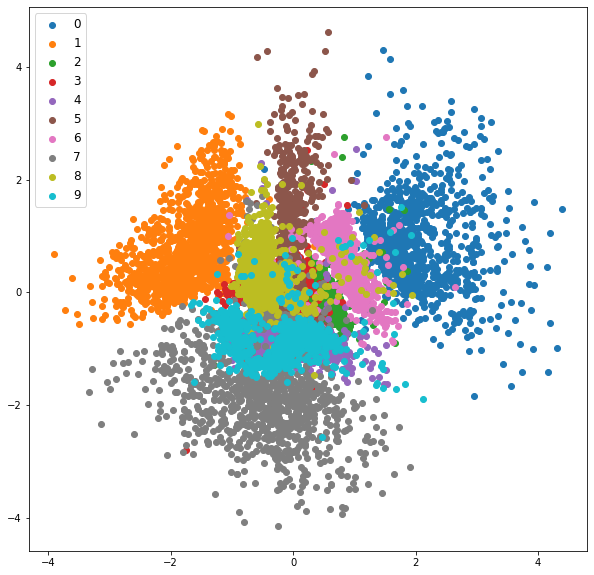

In [ ]:
def plot_scatter(model, loader):
    # get z sampling
    model.cpu()
    z_sampled = []
    label_sampled = []
    for imgs, labels in loader:
        _, _, _, z = model(imgs)
        z_sampled.append(z) # z[b 2]
        label_sampled.append(labels)
    del imgs
    z_to_plot = torch.cat(z_sampled, dim=0).cpu() # z[n 2]
    label_to_plot = torch.cat(label_sampled, dim=0)
    z_to_plot = z_to_plot[:10000,:]
    label_to_plot = label_to_plot[:10000]
    # plot
    x_data = z_to_plot[:,0].squeeze().detach().numpy()
    y_data = z_to_plot[:,1].squeeze().detach().numpy()
    label_data = label_to_plot[:].squeeze().detach().numpy()
    plot_group = [[[],[]], [[],[]], [[],[]], [[],[]], [[],[]], [[],[]], [[],[]], [[],[]], [[],[]], [[],[]]]
    for idx in range(len(x_data)):
        label = label_data[idx]
        plot_group[label][0].append(x_data[idx])
        plot_group[label][1].append(y_data[idx])
    plt.figure(figsize=(10,10))
    for number, group in enumerate(plot_group):
        x, y = group
        plt.scatter(x, y, label = str(number))
    plt.legend(fontsize=12, loc='upper left')
    plt.show()
    return None
# exs
plot_scatter(trained_vae, test_loader)

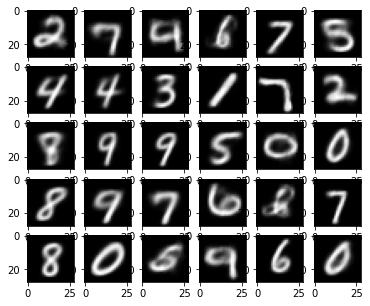

In [ ]:
with torch.no_grad():
    # get z from normal distribution
    vae.cuda()
    z = torch.randn(64, 2).cuda()
    sample = vae.decoder(z).cuda()
# plot
fig = plt.figure(figsize=(6, 5))
for idx in range(30):
    img = sample[idx].cpu().squeeze().view(28, 28).detach().numpy()
    ax = fig.add_subplot(5, 6, idx + 1)
    ax.imshow(img, cmap=cm.gray)
plt.show()

# **Conditional Variational Autoencoder**


Epoch: 1 loss: 193.3387


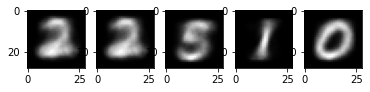

Epoch: 2 loss: 174.9467


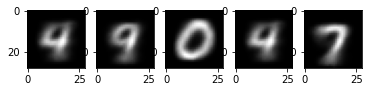

Epoch: 3 loss: 173.8798


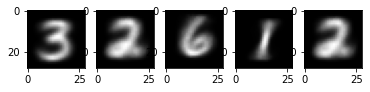

Epoch: 4 loss: 173.6343


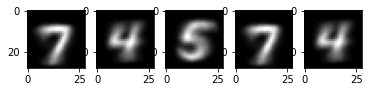

Epoch: 5 loss: 173.5308


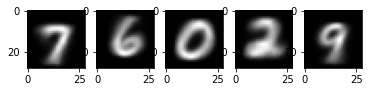

Epoch: 6 loss: 173.4676


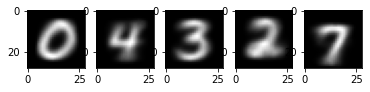

Epoch: 7 loss: 173.4285


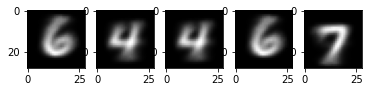

Epoch: 8 loss: 173.3785


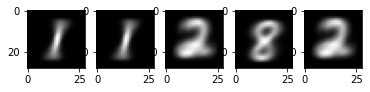

Epoch: 9 loss: 173.3151


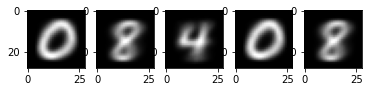

Epoch: 10 loss: 173.3137


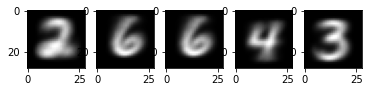

Epoch: 11 loss: 173.2765


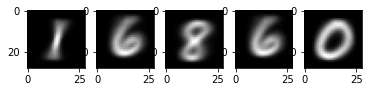

Epoch: 12 loss: 173.2467


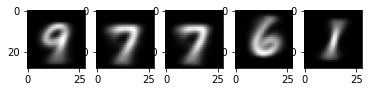

Epoch: 13 loss: 173.2374


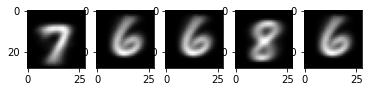

Epoch: 14 loss: 173.2131


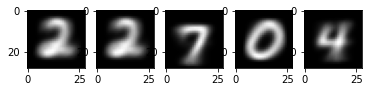

Epoch: 15 loss: 173.2067


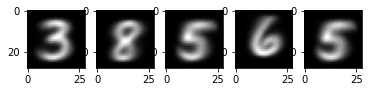

Epoch: 16 loss: 173.2013


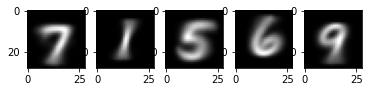

Epoch: 17 loss: 173.1714


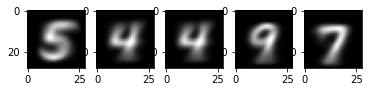

Epoch: 18 loss: 173.1829


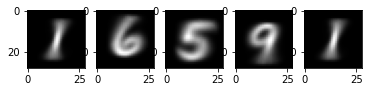

Epoch: 19 loss: 173.1537


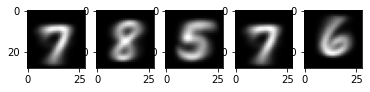

Epoch: 20 loss: 173.1589


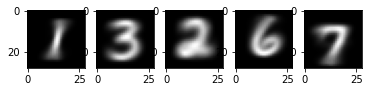

Epoch: 21 loss: 173.1476


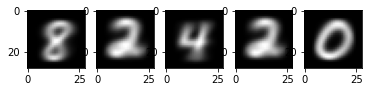

Epoch: 22 loss: 173.1389


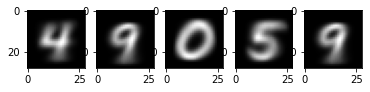

Epoch: 23 loss: 173.1450


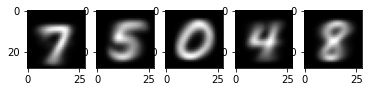

Epoch: 24 loss: 173.1350


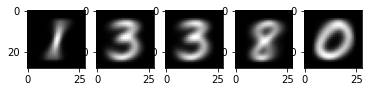

Epoch: 25 loss: 173.1329


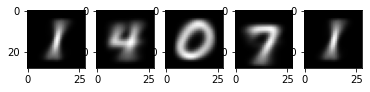

Epoch: 26 loss: 173.1287


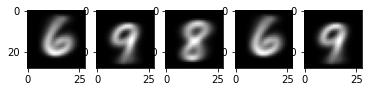

Epoch: 27 loss: 173.1262


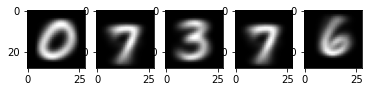

Epoch: 28 loss: 173.1246


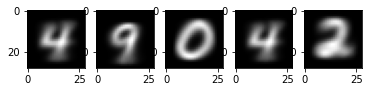

Epoch: 29 loss: 173.1229


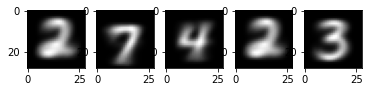

In [ ]:
import numpy as np
import random as random
import time as time
from tqdm import tqdm
from torch.utils.data import DataLoader
from torchvision.datasets import MNIST
from torchvision import transforms
from torch import optim
from matplotlib import pyplot as plt
from matplotlib import cm
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms
from torch.autograd import Variable
from torchvision.utils import save_image

bs = 100
# MNIST Dataset
train_dataset = datasets.MNIST(root='./mnist_data/', train=True, transform=transforms.ToTensor(), download=True)
test_dataset = datasets.MNIST(root='./mnist_data/', train=False, transform=transforms.ToTensor(), download=False)

# Data Loader (Input Pipeline)
train_loader = torch.utils.data.DataLoader(dataset=train_dataset, batch_size=bs, shuffle=True)
test_loader = torch.utils.data.DataLoader(dataset=test_dataset, batch_size=bs, shuffle=False)



class CVAE(nn.Module):
    def __init__(self, x_dim, h_dim1, h_dim2, z_dim):
        super(CVAE, self).__init__()
        
        # encoder part
        self.fc1 = nn.Linear(x_dim, h_dim1)
        self.fc2 = nn.Linear(h_dim1, h_dim2)
        self.fc31 = nn.Linear(h_dim2, z_dim)
        self.fc32 = nn.Linear(h_dim2, z_dim)
        # decoder part
        self.fc4 = nn.Linear(z_dim, h_dim2)
        self.fc5 = nn.Linear(h_dim2, h_dim1)
        self.fc6 = nn.Linear(h_dim1, x_dim)
        self.relu = nn.ReLU()
        # emb
        self.emb1 = nn.Linear(10, 2)
        self.emb21 = nn.Linear(4, 2)
        self.emb22 = nn.Linear(4, 2)
        self.decoder_emb = nn.Linear(12, 2)

    def encoder(self, x, label):
        h = F.relu(self.fc1(x))
        h = F.relu(self.fc2(h))
        label = F.relu(self.emb1(label)) # 2
        mu, logvar = F.relu(self.fc31(h)), F.relu(self.fc32(h)) # 2
        mu = self.emb21(torch.cat([mu, label], dim=1)) # 4 to 2
        logvar = self.emb22(torch.cat([logvar, label], dim=1)) # 4 to 2
        return mu, logvar
    
    def sampling(self, mu, log_var):
        std = torch.exp(0.5*log_var)
        eps = torch.randn_like(std)
        return eps.mul(std).add_(mu) # return z sample
        
    def decoder(self, z):
        h = self.fc4(z)
        h = self.relu(self.fc4(z))
        h = self.relu(self.fc5(h))
        return torch.sigmoid(self.fc6(h))
    
    def forward(self, x, label):
        mu, log_var = self.encoder(x.view(-1, 784), label)
        z = self.sampling(mu, log_var)
        z_ = torch.cat([z, label], dim=1)
        z_ = self.decoder_emb(z_)
        return self.decoder(z_), mu, log_var, z

# build model
cvae = CVAE(x_dim=784, h_dim1= 512, h_dim2=256, z_dim=2)
if torch.cuda.is_available():
    cvae.cuda()



optimizer = optim.Adam(cvae.parameters())
# return reconstruction error + KL divergence losses
def loss_function(recon_x, x, mu, log_var):
    BCE = F.binary_cross_entropy(recon_x, x.view(-1, 784), reduction='sum')
    KLD = -0.5 * torch.sum(1 + log_var - mu.pow(2) - log_var.exp())
    return BCE + KLD

def train(epoch):
    cvae.train()
    train_loss = 0
    for batch_idx, (data, label) in enumerate(train_loader):
        data = data.cuda()
        label = idx_to_one_hot(label)
        label = label.cuda()
        optimizer.zero_grad()
        recon_batch, mu, log_var, _ = cvae(data, label)
        loss = loss_function(recon_batch, data, mu, log_var)
        
        loss.backward()
        train_loss += loss.item()
        optimizer.step()
    print('Epoch: {} loss: {:.4f}'.format(epoch, train_loss / len(train_loader.dataset)))
    imgs_regen = recon_batch
    # plot
    fig = plt.figure(figsize=(6, 30))
    for idx in range(5):
        img = imgs_regen[idx].cpu().squeeze().view(28, 28).detach().numpy()
        ax = fig.add_subplot(1, 5, idx + 1)
        ax.imshow(img, cmap=cm.gray)
    plt.show()


# idx to one hot [b] to [b n]
def idx_to_one_hot(idx):
    b = idx.size(0)
    one_hot = torch.zeros(b, 10)
    for i in range(b):
        j = int(idx[i].item())
        one_hot[i,j] = 1
    return one_hot


################################################################################
# main #########################################################################
for epoch in range(1, 30):
    train(epoch)
trained_cvae = cvae
################################################################################

In [ ]:
def plot_scatter(model, loader):
    # get z sampling
    model.cpu()
    z_sampled = []
    label_sampled = []
    for imgs, labels in loader:
        labels_one_hot = idx_to_one_hot(labels)
        _, _, _, z = model(imgs, labels_one_hot)
        z_sampled.append(z) # z[b 2]
        label_sampled.append(labels)
    del imgs
    z_to_plot = torch.cat(z_sampled, dim=0).cpu() # z[n 2]
    label_to_plot = torch.cat(label_sampled, dim=0)
    z_to_plot = z_to_plot[:10000,:]
    label_to_plot = label_to_plot[:10000]
    # plot
    x_data = z_to_plot[:,0].squeeze().detach().numpy()
    y_data = z_to_plot[:,1].squeeze().detach().numpy()
    label_data = label_to_plot[:].squeeze().detach().numpy()
    plot_group = [[[],[]], [[],[]], [[],[]], [[],[]], [[],[]], [[],[]], [[],[]], [[],[]], [[],[]], [[],[]]]
    for idx in range(len(x_data)):
        label = label_data[idx]
        plot_group[label][0].append(x_data[idx])
        plot_group[label][1].append(y_data[idx])
    plt.figure(figsize=(10,10))
    for number, group in enumerate(plot_group):
        x, y = group
        plt.scatter(x, y, label = str(number), marker='o')
    plt.legend(fontsize=12, loc='upper left')
    plt.show()
    return None
# exs
plot_scatter(trained_cvae, test_loader)

NameError: ignored

0


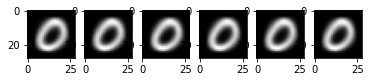

1


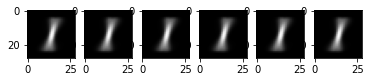

2


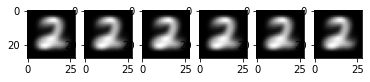

3


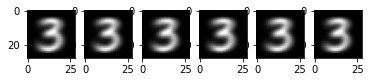

4


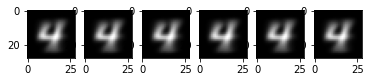

5


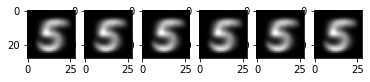

6


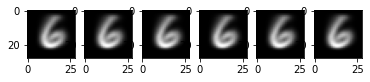

7


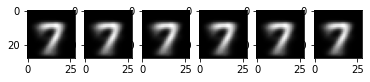

8


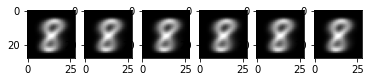

9


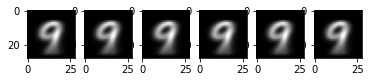

In [ ]:
for want_to_print in range(10):
    with torch.no_grad():
        # get z from normal distribution
        z = torch.randn(64, 2)
        label = want_to_print * torch.ones(64, 1)
        label = idx_to_one_hot(label)
        z_ = torch.cat([z, label], dim=1)
        z_ = trained_cvae.decoder_emb(z_)
        sample = trained_cvae.decoder(z_)
    # plot
    print(want_to_print)
    fig = plt.figure(figsize=(6, 1))
    for idx in range(6):
        img = sample[idx].cpu().squeeze().view(28, 28).detach().numpy()
        ax = fig.add_subplot(1, 6, idx + 1)
        ax.imshow(img, cmap=cm.gray)
    plt.show()

# **GAN**

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms
from torch.autograd import Variable
from torchvision.utils import save_image

# Device configuration
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')


bs = 100

# MNIST Dataset
transform = transforms.Compose([
    transforms.ToTensor(),
    ])

train_dataset = datasets.MNIST(root='./mnist_data/', train=True, transform=transform, download=True)
test_dataset = datasets.MNIST(root='./mnist_data/', train=False, transform=transform, download=False)

# Data Loader (Input Pipeline)
train_loader = torch.utils.data.DataLoader(dataset=train_dataset, batch_size=bs, shuffle=True)
test_loader = torch.utils.data.DataLoader(dataset=test_dataset, batch_size=bs, shuffle=False)

class Generator(nn.Module):
    def __init__(self, g_input_dim, g_output_dim):
        super(Generator, self).__init__()       
        self.fc1 = nn.Linear(g_input_dim, 256)
        self.fc2 = nn.Linear(self.fc1.out_features, self.fc1.out_features*2)
        self.fc3 = nn.Linear(self.fc2.out_features, self.fc2.out_features*2)
        self.fc4 = nn.Linear(self.fc3.out_features, g_output_dim)
    
    # forward method
    def forward(self, x): 
        x = F.leaky_relu(self.fc1(x), 0.2)
        x = F.leaky_relu(self.fc2(x), 0.2)
        x = F.leaky_relu(self.fc3(x), 0.2)
        return torch.tanh(self.fc4(x))
    
class Discriminator(nn.Module):
    def __init__(self, d_input_dim):
        super(Discriminator, self).__init__()
        self.fc1 = nn.Linear(d_input_dim, 1024)
        self.fc2 = nn.Linear(self.fc1.out_features, self.fc1.out_features//2)
        self.fc3 = nn.Linear(self.fc2.out_features, self.fc2.out_features//2)
        self.fc4 = nn.Linear(self.fc3.out_features, 1)
    
    # forward method
    def forward(self, x):
        x = F.leaky_relu(self.fc1(x), 0.2)
        x = F.dropout(x, 0.3)
        x = F.leaky_relu(self.fc2(x), 0.2)
        x = F.dropout(x, 0.3)
        x = F.leaky_relu(self.fc3(x), 0.2)
        x = F.dropout(x, 0.3)
        return torch.sigmoid(self.fc4(x))


# build network
z_dim = 100
mnist_dim = train_dataset.train_data.size(1) * train_dataset.train_data.size(2)

G = Generator(g_input_dim = z_dim, g_output_dim = mnist_dim).to(device)
D = Discriminator(mnist_dim).to(device)


# loss
criterion = nn.BCELoss() 

# optimizer
lr = 0.0002 
G_optimizer = optim.Adam(G.parameters(), lr = lr)
D_optimizer = optim.Adam(D.parameters(), lr = lr)



def D_train(x):
    #=======================Train the discriminator=======================#
    D.zero_grad()

    # train discriminator on real
    x_real, y_real = x.view(-1, mnist_dim), torch.ones(bs, 1)
    x_real, y_real = Variable(x_real.to(device)), Variable(y_real.to(device))

    D_output = D(x_real)
    D_real_loss = criterion(D_output, y_real)
    D_real_score = D_output

    # train discriminator on facke
    z = Variable(torch.randn(bs, z_dim).to(device))
    x_fake, y_fake = G(z), Variable(torch.zeros(bs, 1).to(device))

    D_output = D(x_fake)
    D_fake_loss = criterion(D_output, y_fake)
    D_fake_score = D_output

    # gradient backprop & optimize ONLY D's parameters
    D_loss = D_real_loss + D_fake_loss
    D_loss.backward()
    D_optimizer.step()
        
    return  D_loss.data.item()


def G_train(x):
    #=======================Train the generator=======================#
    G.zero_grad()

    z = Variable(torch.randn(bs, z_dim).to(device))
    y = Variable(torch.ones(bs, 1).to(device))

    G_output = G(z)
    D_output = D(G_output)
    G_loss = criterion(D_output, y)

    # gradient backprop & optimize ONLY G's parameters
    G_loss.backward()
    G_optimizer.step()
        
    return G_loss.data.item()

n_epoch = 50
for epoch in range(1, n_epoch+1):           
    D_losses, G_losses = [], []
    for batch_idx, (x, _) in enumerate(train_loader):
        D_losses.append(D_train(x))
        G_losses.append(G_train(x))

    print('[%d/%d]: loss_d: %.3f, loss_g: %.3f' % (
            (epoch), n_epoch, torch.mean(torch.FloatTensor(D_losses)), torch.mean(torch.FloatTensor(G_losses))))
    
with torch.no_grad():
    test_z = Variable(torch.randn(bs, z_dim).to(device))
    generated = G(test_z)
    save_image(generated.view(generated.size(0), 1, 28, 28), './samples/sample_' + '.png')
